__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Polygon

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_flat.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

20463


,title,adr,latitude,longitude,priceM,ts
14865,"1-к. квартира, 53 м², 9/10 эт.","улица Генерала Крейзера, д. 8, корп. 5",44.60,33.51,8.47,2022-09-05 14:02:00
2488,"1-к. квартира, 43,6 м², 2/9 эт.","улица Токарева, 7 этап, блок-секция 2",44.58,33.51,6.98,2022-08-26 17:29:00
4808,"1-к. квартира, 44,8 м², 5/16 эт.","Севастополь, улица Александра Маринеско, 1б/1",44.58,33.47,6.70,2022-08-29 13:16:00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20463 entries, 0 to 20462
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   avito_id       17454 non-null  float64       
 1   title          20463 non-null  object        
 2   price          20463 non-null  int64         
 3   adr            20463 non-null  object        
 4   description    20463 non-null  object        
 5   obj_name       20463 non-null  object        
 6   ts             20463 non-null  datetime64[ns]
 7   avito_page     17454 non-null  float64       
 8   nrooms         20463 non-null  int64         
 9   floor          20463 non-null  int64         
 10  nfloors        20463 non-null  int64         
 11  area           20463 non-null  float64       
 12  is_studio      20463 non-null  bool          
 13  is_apartment   20463 non-null  bool          
 14  is_part        20463 non-null  bool          
 15  is_auction     2046

In [7]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

20463
19475


In [8]:
# # берём самые свежие объявления
# print(len(df))
# df = df[ (df['ts']==df['ts'].max()) ].reset_index(drop=True)
# print(len(df))

In [9]:
# cols = ['title','adr','latitude','longitude','priceM']
# df[cols]

### ограничиваем тип объекта 

In [10]:
print(len(df))
# выкидываем "ущербные" варианты 
df = df.query('~(is_studio|is_apartment|is_part|is_auction|is_openspace|is_SNT|is_roof)&(nrooms>0)&(nrooms<4)')
print(len(df))

19475
16059


In [11]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
5715,"3-к. квартира, 76 м², 3/5 эт.","Античный проспект , 3",44.59,33.44,13.00
14998,"3-к. квартира, 76,6 м², 5/9 эт.","улица Токарева, 7 этап, блок-секция 1",44.58,33.51,10.34
15728,"2-к. квартира, 68,4 м², 6/9 эт.","улица Токарева, 7 этап, блок-секция 1",44.58,33.51,9.58


In [12]:
del df

## общая статистика изменение цены

In [13]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['nrooms','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)

stat

count  mean  std  min   10%   25%   50%   75%   90%    max
nrooms dt                                                                     
1      2022-08-26 1124.00  6.34 1.83 1.59  4.44  5.20  6.10  7.31  8.50  18.50
       2022-08-29 1118.00  6.32 1.81 1.75  4.50  5.15  6.00  7.30  8.50  18.50
       2022-08-31 1117.00  6.40 1.83 1.30  4.60  5.20  6.11  7.50  8.70  18.50
       2022-09-01 1086.00  6.41 1.80 1.30  4.63  5.23  6.16  7.40  8.50  18.50
       2022-09-02  295.00  6.54 1.77 3.80  4.81  5.23  5.95  7.41  9.35  12.10
       2022-09-05  298.00  6.47 1.74 3.60  4.81  5.23  5.90  7.21  9.35  12.10
       2022-09-06  294.00  6.46 1.74 3.60  4.80  5.20  5.95  7.20  9.35  12.10
       2022-09-07  267.00  6.51 1.76 3.60  4.81  5.23  5.86  7.35  9.35  12.10
       2022-09-08  955.00  5.96 2.28 1.40  3.49  4.50  5.50  7.20  8.99  18.50
       2022-09-12  880.00  5.86 2.27 1.40  3.49  4.48  5.43  7.00  8.57  18.50
2      2022-08-26  926.00  8.88 3.28 3.35  5.90  6.60  8.18 10.29 12.75  36.00
       2022-08-29  921.00  8.92 3.28 3.50  5.90  6.70  8.20 10.50 12.65  36.00
       2022-08-31  911.00  8.88 3.17 2.60  5.90  6.70  8.15 10.45 12.85  35.00
       2022-09-01  936.00  8.95 3.30 3.40  5.90  6.70  8.20 10.50 12.93  36.00
       2022-09-02  112.00  9.66 2.65 4.91  6.36  7.55  9.43 11.53 12.97  15.70
       2022-09-05  131.00  9.76 2.70 4.92  6.40  8.00  9.28 11.37 13.65  15.70
       2022-09-06  187.00  9.71 2.69 4.91  6.32  7.83  9.28 11.45 13.65  15.70
       2022-09-07  128.00  9.75 2.85 4.91  6.20  7.49  9.14 11.77 13.93  15.70
       2022-09-08  560.00  9.44 4.16 3.20  6.00  6.74  8.39 11.13 13.65  49.12
       2022-09-12  475.00  9.26 4.34 3.00  5.69  6.60  8.25 10.88 13.63  49.12
3      2022-08-26  635.00 11.71 6.15 3.85  7.50  8.35 10.33 13.47 16.90 100.00
       2022-08-29  625.00 11.75 6.18 3.85  7.50  8.50 10.33 13.45 16.82 100.00
       2022-08-31  631.00 11.72 6.12 3.85  7.50  8.50 10.33 13.20 17.30 100.00
       2022-09-01  625.00 11.65 6.14 3.85  7.50  8.40 10.21 13.10 16.96 100.00
       2022-09-02   61.00 11.17 1.74 7.73 10.21 10.33 10.35 11.53 13.90  16.64
       2022-09-05   67.00 11.22 1.85 7.73 10.21 10.33 10.35 12.03 14.18  16.64
       2022-09-06   65.00 11.22 1.87 7.73 10.21 10.33 10.34 11.53 14.27  16.64
       2022-09-07   58.00 11.26 1.81 9.20 10.21 10.33 10.35 11.35 14.13  16.64
       2022-09-08  298.00 11.98 5.67 5.00  7.64  9.15 10.35 13.50 17.36  56.52
       2022-09-12  273.00 11.99 6.02 5.00  7.60  9.00 10.33 13.50 17.40  56.52

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

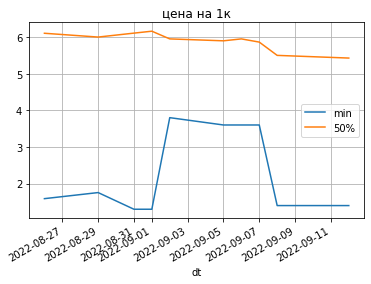

In [14]:
stat.loc[1,['min','25%','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

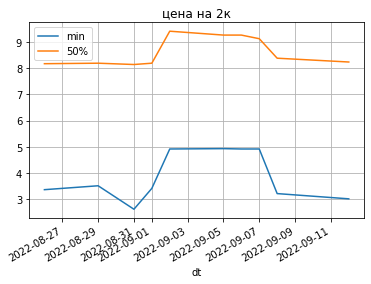

In [15]:
stat.loc[2,['min','25%','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

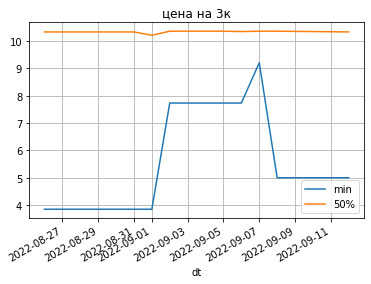

In [16]:
stat.loc[3,['min','25%','50%']].plot(grid=True,title='цена на 3к')

## ограничиваем по район поиска

In [17]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')
# frames_index

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames['area_id'] = range(len(frames))

frames

,area_name,geometry,area_id
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))",0
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))",1
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))",2
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))",3
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))",4
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))",5


<AxesSubplot:>

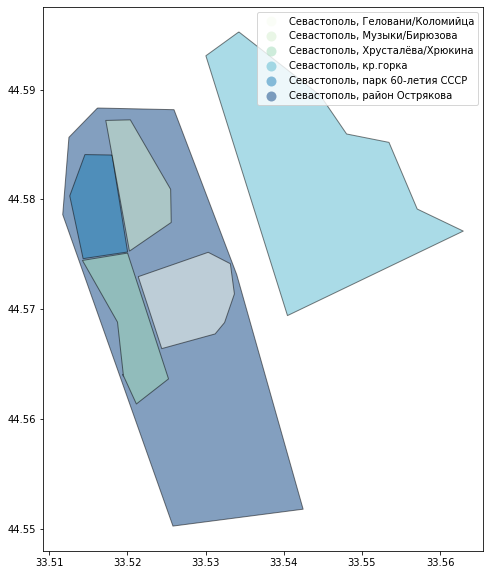

In [18]:
frames.plot('area_name', legend=True, cmap='GnBu', alpha=.5, edgecolor='k',figsize=(10,10),)  

In [19]:
frames.explore('area_name', legend=True)

In [20]:
# ctx.add_basemap(
#     frames.plot('area_name',legend=True,cmap='GnBu',figsize=(31,31),alpha=.5,edgecolor='k'), 
#     crs=gdf.crs, 
#     zoom=16,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

In [21]:
# фильтруем по области
print(len(gdf))
gdf_in_frame = gdf.sjoin( frames.query('area_id in (1,2)'), how='inner', predicate='within') 
print(len(gdf_in_frame))

16059
330


In [22]:
gdf_in_frame[['title','priceM','adr','geometry']].explore( legend=False)

In [23]:
# ctx.add_basemap(
#     gdf_in_frame[ (gdf_in_frame['dt']==gdf_in_frame['dt'].max()) ]
#       .plot(figsize=(21,21), color='r',marker='*'), 
#     crs=gdf.crs, 
#     zoom=16,
#     # source=ctx.providers.Stamen.TonerLite,
#     source=ctx.providers.OpenStreetMap.Mapnik,
# )

### изменение цены

In [24]:
stat = gdf_in_frame.groupby(['nrooms','dt',])['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
stat

count  mean  std  min  10%  25%  50%  75%   90%   max
nrooms dt                                                               
1      2022-08-26  24.00  5.25 0.80 3.90 4.43 4.79 5.20 5.64  5.80  8.00
       2022-08-29  31.00  5.41 0.80 4.30 4.50 4.88 5.30 5.78  5.90  8.00
       2022-08-31  31.00  5.46 0.80 4.20 4.50 4.93 5.50 5.80  6.10  8.00
       2022-09-01  29.00  5.51 0.80 4.20 4.74 4.95 5.60 5.80  6.12  8.00
2      2022-08-26  43.00  7.23 1.10 5.40 5.82 6.50 7.00 8.07  8.50  9.50
       2022-08-29  44.00  7.25 1.18 5.40 5.76 6.45 7.00 8.20  9.06  9.50
       2022-08-31  48.00  7.18 1.09 5.30 5.90 6.50 7.00 8.04  8.50  9.50
       2022-09-01  50.00  7.12 1.12 5.30 5.75 6.50 6.97 7.97  8.50  9.50
3      2022-08-26   9.00  8.26 2.08 6.90 6.90 7.50 7.70 7.95  9.38 13.68
       2022-08-29   8.00  8.33 2.21 6.90 6.90 7.35 7.70 8.04  9.91 13.68
       2022-08-31   7.00  8.42 2.38 6.90 6.90 7.20 7.70 8.12 10.45 13.68
       2022-09-01   6.00  8.67 2.50 6.90 7.20 7.55 7.83 8.21 10.99 13.68

<AxesSubplot:title={'center':'цена на 1к'}, xlabel='dt'>

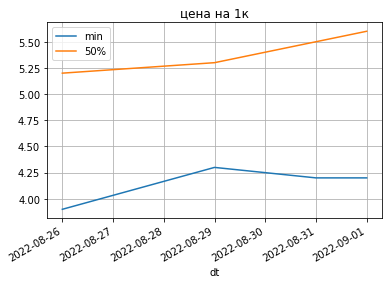

In [25]:
stat.loc[1,['min','50%']].plot(grid=True, title='цена на 1к')

<AxesSubplot:title={'center':'цена на 2к'}, xlabel='dt'>

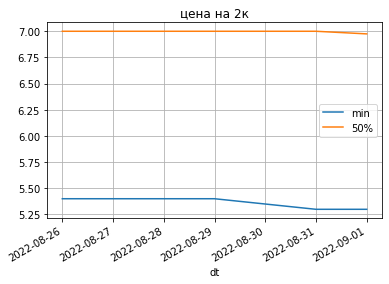

In [26]:
stat.loc[2,['min','50%']].plot(grid=True, title='цена на 2к')

<AxesSubplot:title={'center':'цена на 3к'}, xlabel='dt'>

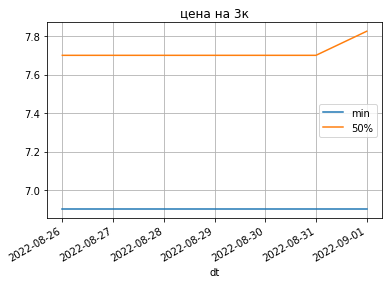

In [27]:
stat.loc[3,['min','50%']].plot(grid=True,title='цена на 3к')

## гексагональная сетка

In [28]:
import h3
    
def cover_grid_hexagonal(gmtr,cell_size=9,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame(
        { 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },
        crs=crs, 
    )

grid = cover_grid_hexagonal( frames.query('area_id==0').geometry.values[0] )
print(len(grid))
grid.sample(2)

54


,hex_id,geometry
26,892d289424bffff,"POLYGON ((33.53201 44.56235, 33.53169 44.56056, 33.53377 44.55940, 33.53618 44.56002, 33.53651 44.56181, 33.53442 44.56297, 33.53201 44.56235))"
45,892d2895197ffff,"POLYGON ((33.52928 44.55993, 33.52895 44.55814, 33.53104 44.55698, 33.53345 44.55761, 33.53377 44.55940, 33.53169 44.56056, 33.52928 44.55993))"


In [29]:
# ctx.add_basemap( 
#     grid.plot(alpha=.5,color='yellow',edgecolors='blue',figsize=(31,31),), 
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )

### медиана актуальной цены

In [30]:
ts = '2022-08-01' # ограничиваем дату

In [31]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM') #'area_name', legend=True)

### количество предложений

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {  return false; }

<IPython.core.display.Javascript object>

In [33]:
# количество предложений
from folium import Map
from folium.plugins import HeatMap

start_pos = (44.578330, 33.516509)

Map(
    location=start_pos,
    zoom_start=15,
    # width=500,
    #height=2000,
).add_child( 
    HeatMap( 
        gdf[ gdf['dt']>ts ]
        .sjoin(frames,how='inner',predicate='within')[['latitude','longitude',]],
        #radius=10.,
        #min_opacity=3. 
    )
)


In [34]:
# gdf

In [35]:
grid_values = (
    grid.sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

# grid.merge(grid_values,on='hex_id').explore('priceM') #'area_name', legend=True)


In [36]:
# grid_values

In [37]:
# grid

In [38]:
# grid_values.sample(2)
# grid.sample(2)

In [39]:
import folium

# Create a map
my_map = folium.Map(location=start_pos, zoom_start=14,)

# Add the data
folium.Choropleth(
    name='choropleth',
    geo_data=grid,
    data=grid_values,
    columns=['hex_id','priceM',],
    key_on='feature.properties.hex_id',
    fill_color='YlOrRd',
    fill_opacity=.7,
    line_opacity=.2,
    legend_name='priceM median'
).add_to(my_map)
my_map

In [40]:
#grid.merge(grid_values).explode(
    #'priceM', 
    #alpha=.5,
    #edgecolors='blue',
    # cmap='rainbow',
    #figsize=(31,31), 
    #legend=True, 
#)

# ax.set(title='медиана цены (в млн.руб.)')

# ctx.add_basemap( 
#     ax,
#     source=ctx.providers.OpenStreetMap.Mapnik,
#     crs=grid.crs, 
#     zoom=16,
# )


# frid.explore('area_name', legend=True)